## [Chapter 2](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb)

Notes and exercises from Cam Davidson's *[Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from IPython.display import display
from scipy import stats
from scipy.misc import comb as nCk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb

import daft
import theano.tensor as tt
import pymc3 as pm

np.random.seed(865)

'Done'

/home/alex/.envs/think-series/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'Done'

## More on PyMC3

In [2]:
with pm.Model() as theano_test:
    
    # Complementary probabilities for two categories.
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    
    # Combine the two variables above into a theano tensor,
    # which can be understood by the Categorical variable.
    p = tt.stack([p1, p2]) 
    assignment = pm.Categorical('assignment', p)
    
'Done'

'Done'

In [3]:
n_data_points = 5
idx = np.arange(n_data_points)

with pm.Model() as model:
    lam1 = pm.Exponential('lam1', 1.0)
    lam2 = pm.Exponential('lam2', 1.0)
    tau = pm.DiscreteUniform('tau', lower=0, upper=10)
    lam_switch = pm.math.switch(tau >= idx, lam1, lam2)
    
'Done'

'Done'

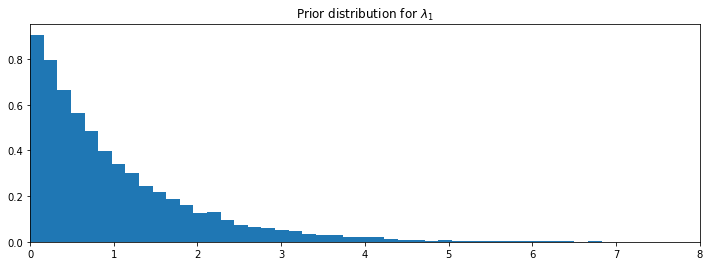

In [4]:
plt.figure(figsize=(12,4))
plt.hist(lam1.random(size=20000), bins=70, density=True)
plt.title('Prior distribution for $\lambda_1$')
plt.xlim(0, 8)
plt.show()

In [5]:
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson('obs', lam_switch, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


## Graphical Model Plate Diagram using Daft Library

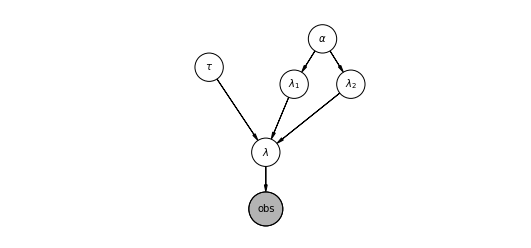

In [6]:
pgm = daft.PGM((9,4), origin=(0.5, 0.5))

# Add the nodes representing random variables.
pgm.add_node(daft.Node("tau", r"$\tau$", 4.0, 3.5))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 6, 4.0))
pgm.add_node(daft.Node("lambda1", r"$\lambda_1$", 5.5, 3.2,))
pgm.add_node(daft.Node("lambda2", r"$\lambda_2$", 6.5, 3.2))
pgm.add_node(daft.Node("lambda", r"$\lambda$", 5.0, 2.0))
pgm.add_node(daft.Node("obs", "obs", 5.0, 1.0, 1.2, observed=True))

# Add edges representing dependencies.
pgm.add_edge("tau", "lambda")
pgm.add_edge("alpha", "lambda1")
pgm.add_edge("alpha", "lambda2")
pgm.add_edge("lambda1", "lambda")
pgm.add_edge("lambda2", "lambda")
pgm.add_edge("lambda", "obs")

pgm.render()
plt.show()

## Bayesian A/B Testing

In [7]:
# Define model for group A conversion.
with pm.Model() as model:
    
    # prior probability of conversions for site A.
    p_A = pm.Uniform('p_A', lower=0, upper=1)

In [10]:
# Simulate fake observed data.
# p_A_true is unknown to the model, but used to generate fake data.
p_A_true = 0.05
N = 5000

conversions = stats.bernoulli.rvs(p_A_true, size=N)
print('Observed frequency = %.5lf' % conversions.mean())
print('Equal to true frequency? %s' % (conversions.mean() == p_A_true))

Observed frequency = 0.05080
Equal to true frequency? False


In [11]:
# Run inference to get a posterior for p_A based on the conversions.
with model:
    obs = pm.Bernoulli('obs', p_A, observed=conversions)
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]
'Done'

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [p_A_interval__]
100%|██████████| 18500/18500 [00:05<00:00, 3167.16it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '12570' (I am process '12571')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/alex/.theano/compiledir_Linux-4.8--generic-x86_64-with-LinuxMint-18.2-sonya-x86_64-3.5.2-64/lock_dir
The number of effective samples is smaller than 25% for some parameters.


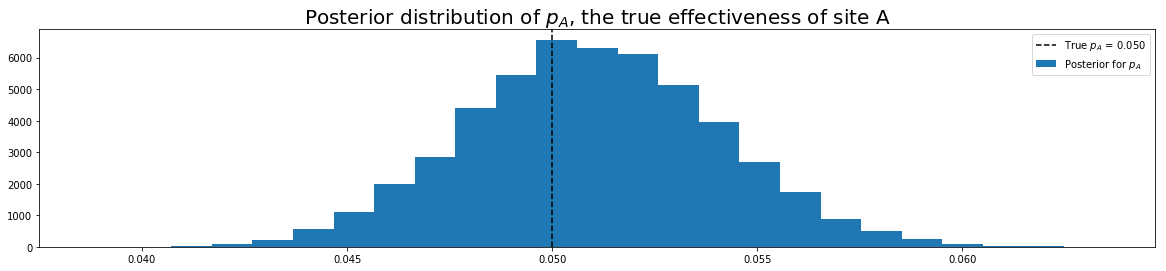

In [12]:
plt.figure(figsize=(20, 4))
plt.title('Posterior distribution of $p_A$, the true effectiveness of site A', size=20)
plt.hist(burned_trace['p_A'], label='Posterior for $p_A$', bins=25)
plt.axvline(p_A_true, label='True $p_A$ = %.3lf' % p_A_true, color='black', linestyle='--')
plt.legend()
plt.show()

Now make a model for both A and B.

In [13]:
# True quantities; again, this is what the model is trying to identify.
p_A_true = 0.05
p_B_true = 0.04

# Numbers of samples.
N_A = 1500
N_B = 800

# Take a random sample using the true parameters.
conversions_A = stats.bernoulli.rvs(p_A_true, size=N_A)
conversions_B = stats.bernoulli.rvs(p_B_true, size=N_B)

print('Observed p_A = %.3lf' % conversions_A.mean())
print('Observed p_B = %.3lf' % conversions_B.mean())

Observed p_A = 0.049
Observed p_B = 0.040


In [14]:
with pm.Model() as model:
    
    # Uniform priors for p_A, p_B.
    p_A = pm.Uniform('p_A', 0, 1)
    p_B = pm.Uniform('p_B', 0, 1)
    
    # Deterministic delta function expressing the diff in p_A, p_B.
    delta = pm.Deterministic('delta', p_A - p_B)
    
    # Assign observations to two Bernoulli random variables, parameterized by p_A, p_B.
    obs_A = pm.Bernoulli('obs_A', p_A, observed=conversions_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed=conversions_B)
    
    # Magic sampling -- explanation coming soon!
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:]
    
'Done'

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [p_B_interval__]
>Metropolis: [p_A_interval__]
100%|██████████| 20500/20500 [00:11<00:00, 1823.98it/s]
The number of effective samples is smaller than 25% for some parameters.


'Done'

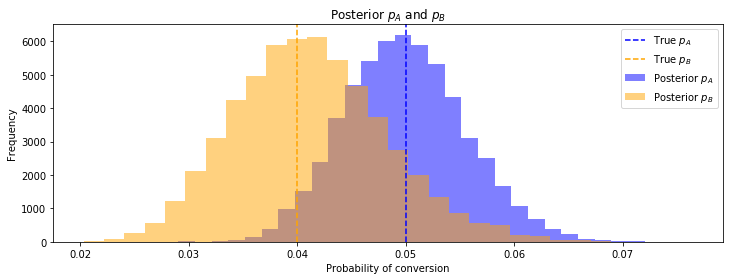

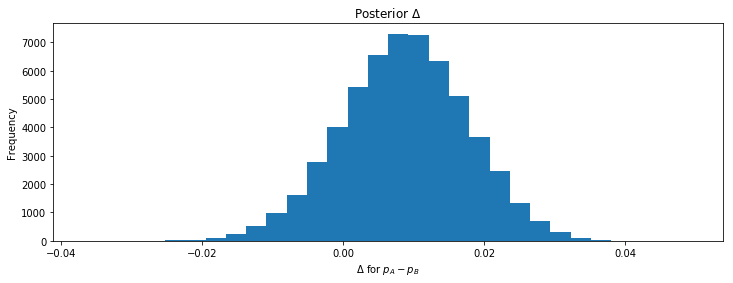

In [15]:
plt.figure(figsize=(12, 4))
plt.hist(burned_trace['p_A'], bins=30, alpha=0.5, color='blue', label='Posterior $p_A$')
plt.hist(burned_trace['p_B'], bins=30, alpha=0.5, color='orange', label='Posterior $p_B$')
plt.axvline(p_A_true, color='blue', linestyle='--', label='True $p_A$')
plt.axvline(p_B_true, color='orange', linestyle='--', label='True $p_B$')
plt.title('Posterior $p_A$ and $p_B$')
plt.xlabel('Probability of conversion')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(burned_trace['delta'], bins=30)
plt.title('Posterior $\Delta$')
plt.xlabel('$\Delta$ for $p_A - p_B$')
plt.ylabel('Frequency')
plt.show()

Use the posterior of delta to compute the probability that site A is better or worse than B:

In [16]:
print('P(A > B) = %.3lf' % (burned_trace['delta'] > 0).mean())
print('P(A < B) = %.3lf' % (burned_trace['delta'] < 0).mean())
print('P(A = B) = %.3lf' % (burned_trace['delta'] == 0).mean())

P(A > B) = 0.838
P(A < B) = 0.162
P(A = B) = 0.000


## Cheating Among Students

Implementing the "Privacy Algorithm" as a PGM.

In [17]:
n_students = N = 100

with pm.Model() as model:
    
    # Random variable p_cheat models the probability that any student cheated,
    # or equivalently, the proportion of students that cheated. This is the
    # variable we are most interested in inferring.
    p_cheat = pm.Uniform('p_cheat', lower=0, upper=1)
    
    # Random variable truth models the binary truth for all N students, parameterized
    # by p_cheat. Initialize with approx. half of the students having cheated.
    truth = pm.Bernoulli('truth', p_cheat, shape=N, testval=np.random.binomial(1, 0.5, N))
    
    # Random variable flip_1 models the first coin flip for all N students, which determines
    # whether the student must tell the truth or flip again.
    flip_1 = pm.Bernoulli('flip_1', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    
    # Random variable flip_2 models the second coin flip for all N students, which determines
    # what the student says if the first flip was tails.
    flip_2 = pm.Bernoulli('flip_2', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    
    # Answer is an array with elements = 1 iff:
    # - the first toss is heads and the student cheated,(i.e. student responded yes honestly) or
    # - the first toss is tails and second is heads (i.e. student responded yes by chance).
    answer = flip_1 * truth + (1 - flip_1) * flip_2
    
    # p_yes is the the proportion of students who answered "yes" to the question of cheating.
    # This will be used to parameterize a Binomial modeling the number of "yes" answers.
    p_yes = pm.Deterministic('p_yes', tt.sum(answer) / float(N))
    
display(model)

Incorporating Data:

- Given the model definition, we should expect 25 "yes" responses as a baseline, because the first flip has probability 0.5 of leading to a second flip, and the second flip has probability 0.5 of evoking a "yes" response.

In [18]:
# Inference gets skipped because this model is very slow.
# It would take roughly 32 minutes to run on my 6-core desktop.

# X = 25
# with model:
#     observations = pm.Binomial('obs', N, p_yes, observed=X)
#     step = pm.Metropolis(vars=[p_cheat])
#     trace = pm.sample(40000, step=step)
#     burned_trace = trace[15000:]
    
'Done'

'Done'

### An Alternative (faster) Model


Given a value of $P(\text{cheat}) = p$, the probability of a "yes" response is:

$P(\text{yes}) \\
= P(\text{flip 1 heads})P(\text{cheat}) + P(\text{flip 1 tails})P(\text{flip 2 heads}) \\
= \frac{1}{2}p + \frac{1}{2}\frac{1}{2} \\
= \frac{p}{2} + \frac{1}{4}$

Knowing this formulation lets us side-step the coin flips, which greatly reduces simulation time, shown below.

In [19]:
N = 100
X = 35

with pm.Model() as model:

    # p_cheat models the proportion of students who actually cheated.
    p_cheat = pm.Uniform('p_cheat', lower=0, upper=1)
    
    # p_yes models the proportion of students who respond yes, as defined above.
    p_yes = pm.Deterministic('p_yes', 0.5 * p_cheat + 0.25)
    
    # obs_yes models the number of observed yes responses, parameterized by p_yes.
    obs_yes = pm.Binomial('obs_yes', N, p_yes, observed=X)
    
    display(model)
    
    # Inference algorithm.
    step = pm.Metropolis()
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]
    
'Done'

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [p_cheat_interval__]
100%|██████████| 40500/40500 [00:09<00:00, 4368.83it/s]
The number of effective samples is smaller than 25% for some parameters.


'Done'

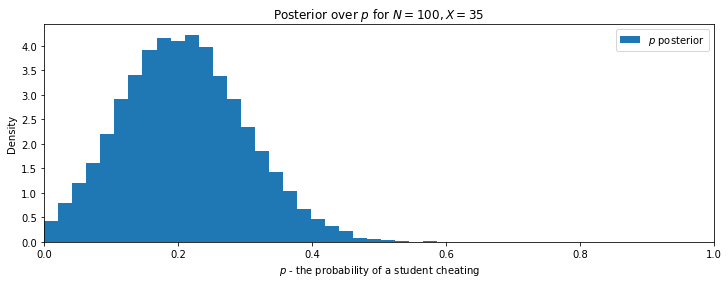

In [20]:
plt.figure(figsize=(12, 4))
plt.title('Posterior over $p$ for $N=%d, X=%d$' % (N, X))
plt.hist(burned_trace['p_cheat'], bins=30, label='$p$ posterior', density=True)
plt.xlim(0, 1)
plt.xlabel('$p$ - the probability of a student cheating')
plt.ylabel('Density')
plt.legend()
plt.show()

## Space Shuttle Disaster

The model should answer the question:

> At temperature $t$, what is the probability of a damage incident?

To represent this probability, we can use a function $p(t)$ that takes a temperature and returns a value in $[0, 1]$

We can use the logistic function, parameterized by $\beta$ with a  bias term $\alpha$.

$p(t) = 1 \diagup 1 + e^{\alpha + \beta t} \in [0, 1]$

$\beta$ controls how quickly the probability rises from 0 to 1, and $\alpha$ controls the temperatures at which this rise occurs. In other words, $\beta$ control's the curves elongation, and $\alpha$ controls the curve's placement along the x-axis.

Start by reading the data and manually fitting a logistic functions:

In [21]:
df = pd.read_csv('davidson/Chapter2_MorePyMC/data/challenger_data.csv', 
                 names=['date', 'temp', 'defect'], 
                 skiprows=1,
                 nrows=23)
df.dropna(inplace=True)
df.defect.replace('Challenger Accident', 1, inplace=True)
df['defect'] = df.defect.astype(int)
display(df)
df.shape

,date,temp,defect
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


(22, 3)

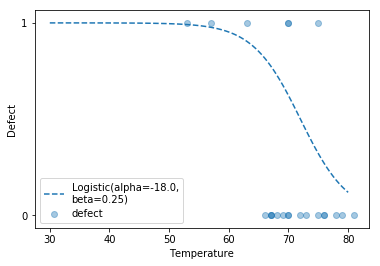

In [22]:
def logistic(t, alpha=0, beta=1):
    return 1 / (1 + np.exp(alpha + np.dot(beta, t)))

plt.scatter(df.temp, df.defect, alpha=0.4)

alpha, beta = -18, 0.25
T = np.linspace(30, 80, 101)
plt.plot(T, logistic(T, alpha, beta), linestyle='--', 
         label='Logistic(alpha=%.1lf,\nbeta=%.2lf)' % (alpha, beta))

plt.yticks([0, 1], [0, 1])
plt.xlabel('Temperature')
plt.ylabel('Defect')
plt.legend()
plt.show()

In [30]:
with pm.Model() as model:
    
    # Define priors for alpha and beta.
    # The small tau implies high uncertaintly.
    beta = pm.Normal('beta', mu=0, tau=0.001, testval=0)
    alpha = pm.Normal('alpha', mu=0, tau=0.001, testval=0)
    
    # Variable p is the logistic function evaluated with beta and alpha.
    # It also includes the observed temperatures, which is quite subtle.
    p = pm.Deterministic('p', 1. / (1 + tt.exp(beta * df.temp + alpha)))
    
    # The observed random variable is a Bernouilli parameterized by p.
    obs = pm.Bernoulli('obs', p, observed=df.defect)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    %time challenger_trace = trace = pm.sample(60000, step=step, start=start)
    
'Done'

logp = -19.372, ||grad|| = 128.75: 100%|██████████| 30/30 [00:00<00:00, 1417.65it/s]  
Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
100%|██████████| 60500/60500 [00:30<00:00, 1996.33it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 4min 53s, sys: 240 ms, total: 4min 53s
Wall time: 5min 24s


'Done'

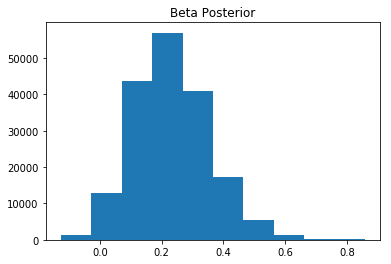

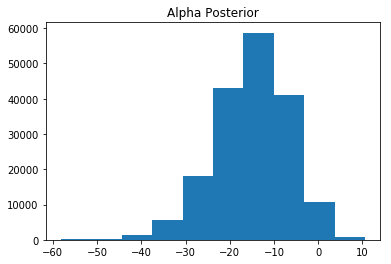

In [24]:
plt.hist(trace['beta'])
plt.title('Beta Posterior')
plt.show()

plt.hist(trace['alpha'])
plt.title('Alpha Posterior')
plt.show()

p_t shape (180000, 50)


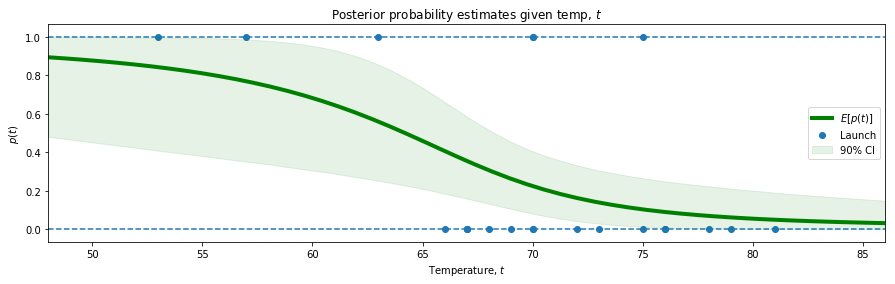

In [25]:
df.temp.min(), df.temp.max()
temps = np.linspace(df.temp.min() - 5, df.temp.max() + 5, 50)

# Possibly confusing dimensions. p_t is len(samples) x len(temps), 
# so every row represents all 50 temperatures evaluated at
# every sample's values of alpha and beta.
p_t = logistic(temps[np.newaxis, :], 
               alpha=trace['alpha'][:, np.newaxis],
               beta=trace['beta'][:, np.newaxis])

print('p_t shape', p_t.shape)

# E[p(t)] is the mean p(t) at each temperature.
p_t_expected = p_t.mean(axis=0)

# Lower and upper bounds for confidence intervals.
p_t_lower = np.percentile(p_t, q=5, axis=0)
p_t_upper = np.percentile(p_t, q=95, axis=0)

plt.figure(figsize=(15, 4))
plt.scatter(df.temp, df.defect, label='Launch')
plt.axhline(1., ls='--')
plt.axhline(0., ls='--')
plt.plot(temps, p_t_expected, label='$E[p(t)]$', lw=4, color='green')
plt.fill_between(temps, p_t_lower, p_t_upper, color='green', alpha=0.1, label='90% CI')
plt.xlim(min(temps), max(temps))
plt.title('Posterior probability estimates given temp, $t$')
plt.xlabel('Temperature, $t$')
plt.ylabel('$p(t)$')
plt.legend()
plt.show()

Now plot the posterior $p(t)$ with temperature $t = 31$, which was the temperature on the day that Challenger launched and crashed.

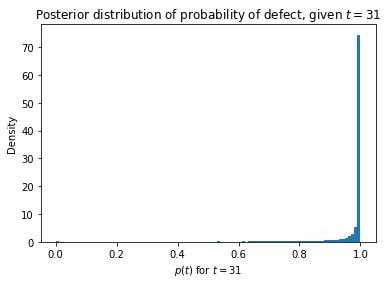

In [26]:
p_t31 = logistic(31, alpha=trace['alpha'], beta=trace['beta'])
plt.hist(p_t31, bins=100, density=True)
plt.xlabel('$p(t)$ for $t = 31$')
plt.ylabel('Density')
plt.title('Posterior distribution of probability of defect, given $t=31$')
plt.show()

## Exercises

1) Try putting in extreme values for our observations in the cheating example. What happens if we observe 25 affirmitive responses? 10? 50?

Running model with X=10, N=100


Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [p_cheat_interval__]
100%|██████████| 40500/40500 [00:09<00:00, 4311.58it/s]
The number of effective samples is smaller than 25% for some parameters.


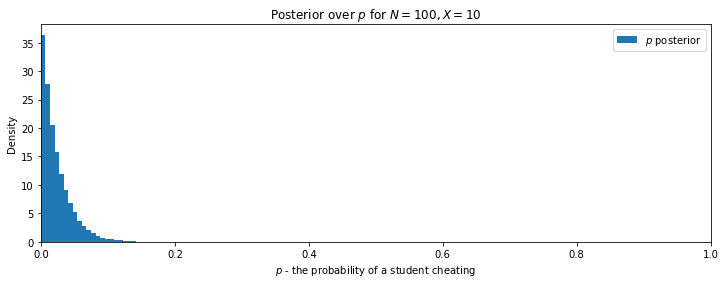

Running model with X=25, N=100


Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [p_cheat_interval__]
100%|██████████| 40500/40500 [00:09<00:00, 4338.89it/s]
The number of effective samples is smaller than 25% for some parameters.


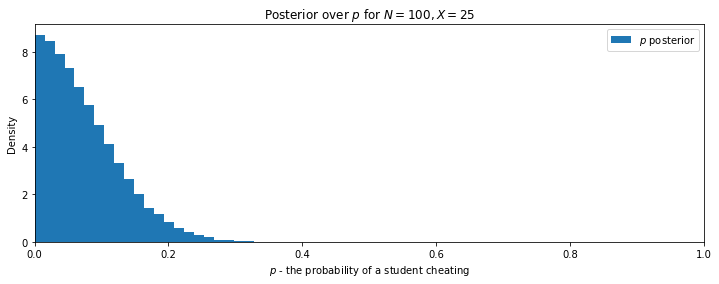

Running model with X=50, N=100


Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [p_cheat_interval__]
100%|██████████| 40500/40500 [00:09<00:00, 4372.76it/s]
The number of effective samples is smaller than 25% for some parameters.


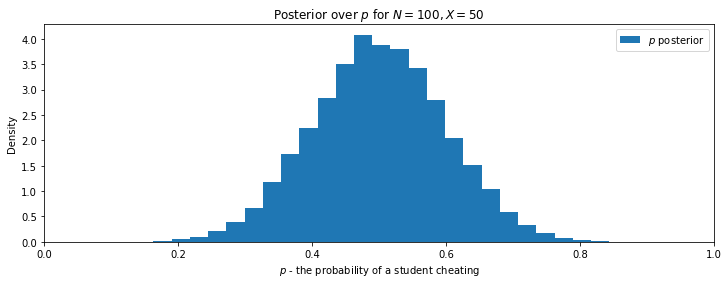

Running model with X=75, N=100


Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [p_cheat_interval__]
100%|██████████| 40500/40500 [00:09<00:00, 4319.60it/s]
The number of effective samples is smaller than 25% for some parameters.


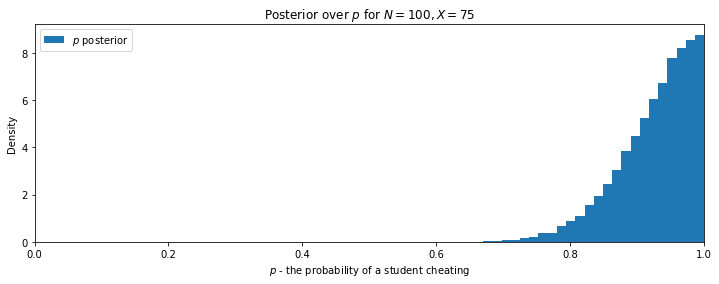

In [29]:
def cheating_model(X, N=100):
    
    print('Running model with X=%d, N=%d' % (X, N))
    
    with pm.Model() as model:

        # p_cheat models the proportion of students who actually cheated.
        p_cheat = pm.Uniform('p_cheat', lower=0, upper=1)

        # p_yes models the proportion of students who respond yes, as defined above.
        p_yes = pm.Deterministic('p_yes', 0.5 * p_cheat + 0.25)

        # obs_yes models the number of observed yes responses, parameterized by p_yes.
        obs_yes = pm.Binomial('obs_yes', N, p_yes, observed=X)

        # Inference algorithm.
        step = pm.Metropolis()
        trace = pm.sample(40000, step=step)
        burned_trace = trace[15000:]
        
    plt.figure(figsize=(12, 4))
    plt.title('Posterior over $p$ for $N=%d, X=%d$' % (N, X))
    plt.hist(burned_trace['p_cheat'], bins=30, label='$p$ posterior', density=True)
    plt.xlim(0, 1)
    plt.xlabel('$p$ - the probability of a student cheating')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
for X in [10, 25, 50, 75]:
    cheating_model(X)

2) Try plotting $\alpha$ versus $\beta$ samples. Why might the resulting plot look like this?

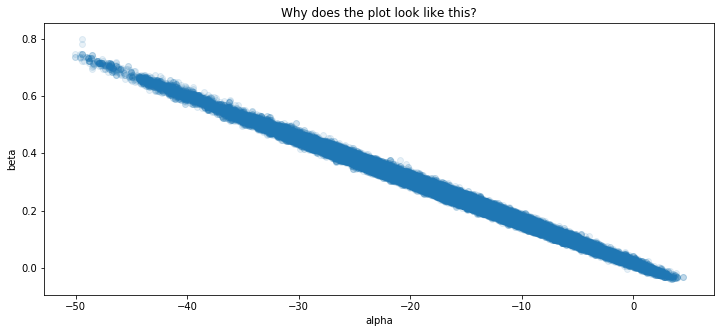

In [50]:
plt.figure(figsize=(12, 5))
plt.scatter(challenger_trace['alpha'], challenger_trace['beta'], alpha=0.1)
plt.title('Why does the plot look like this?')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.show()

In [46]:
print('Alpha mean, standard deviation = (%.3lf, %.3lf)' % (
    challenger_trace['alpha'].mean(), challenger_trace['alpha'].std()))
print('Beta mean, standard deviation = (%.3lf, %.3lf)' % (
    challenger_trace['beta'].mean(), challenger_trace['beta'].std()))

Alpha mean, standard deviation = (-15.616, 7.462)
Beta mean, standard deviation = (0.242, 0.109)


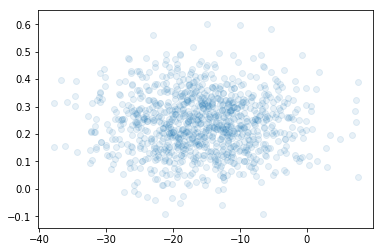

In [47]:
X = np.random.normal(challenger_trace['alpha'].mean(), challenger_trace['alpha'].std(), size=10000)
Y = np.random.normal(challenger_trace['beta'].mean(), challenger_trace['beta'].std(), size=10000)
plt.scatter(X, Y, alpha=0.1)
plt.show()

My best guess: the two posterior random variables are approximately normally distributed, but they are not independent.

On the other hand, two independent normally distributed variables look like the second plot above.